In [1]:
!wget -c https://uni-bonn.sciebo.de/s/f81JqGZmEHXxMnB/download?path=%2F&files=steinmetz_2016-12-14_Cori.nc

--2023-10-24 13:28:11--  https://uni-bonn.sciebo.de/s/f81JqGZmEHXxMnB/download?path=%2F
Resolving uni-bonn.sciebo.de (uni-bonn.sciebo.de)... 128.176.1.2
Connecting to uni-bonn.sciebo.de (uni-bonn.sciebo.de)|128.176.1.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘download?path=%2F’

download?path=%2F       [     <=>            ]   1.16G  67.0MB/s    in 15s     

2023-10-24 13:28:26 (80.7 MB/s) - ‘download?path=%2F’ saved [1241807443]



In [2]:
!unzip /content/download?path=%2F

Archive:  /content/download?path=%2F
   creating: steinmetz_neuromatch_dataset/
 extracting: steinmetz_neuromatch_dataset/steinmetz_2016-12-14_Cori.nc  
 extracting: steinmetz_neuromatch_dataset/steinmetz_2016-12-17_Cori.nc  
 extracting: steinmetz_neuromatch_dataset/steinmetz_2016-12-18_Cori.nc  
 extracting: steinmetz_neuromatch_dataset/steinmetz_2017-01-07_Muller.nc  
 extracting: steinmetz_neuromatch_dataset/steinmetz_2017-01-08_Muller.nc  
 extracting: steinmetz_neuromatch_dataset/steinmetz_2017-01-08_Radnitz.nc  
 extracting: steinmetz_neuromatch_dataset/steinmetz_2017-01-09_Muller.nc  
 extracting: steinmetz_neuromatch_dataset/steinmetz_2017-01-09_Radnitz.nc  
 extracting: steinmetz_neuromatch_dataset/steinmetz_2017-01-10_Radnitz.nc  
 extracting: steinmetz_neuromatch_dataset/steinmetz_2017-01-11_Radnitz.nc  
 extracting: steinmetz_neuromatch_dataset/steinmetz_2017-01-12_Radnitz.nc  
 extracting: steinmetz_neuromatch_dataset/steinmetz_2017-05-15_Moniz.nc  
 extracting: steinmetz

In [4]:
import xarray as xa
dataset = xa.load_dataset('/content/steinmetz_neuromatch_dataset/steinmetz_2016-12-14_Cori.nc')
dataset

<xarray.Dataset>
Dimensions:             (trial: 364, time: 250, cell: 734,
                         waveform_component: 3, sample: 82, probe: 384,
                         brain_area_lfp: 7, spike_id: 2446173)
Coordinates:
  * trial               (trial) int32 1 2 3 4 5 6 7 ... 359 360 361 362 363 364
  * time                (time) float64 0.01 0.02 0.03 0.04 ... 2.48 2.49 2.5
  * cell                (cell) int32 1 2 3 4 5 6 7 ... 729 730 731 732 733 734
  * waveform_component  (waveform_component) int32 1 2 3
  * probe               (probe) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384
  * brain_area_lfp      (brain_area_lfp) object 'ACA' 'LS' ... 'SUB' 'VISp'
  * spike_id            (spike_id) int32 1 2 3 4 ... 2446171 2446172 2446173
Dimensions without coordinates: sample
Data variables: (12/31)
    contrast_left       (trial) int8 100 0 100 0 50 0 0 ... 0 100 50 50 0 25 100
    contrast_right      (trial) int8 0 50 50 0 100 0 0 ... 25 100 25 25 50 0 100
    gocue               (trial) float64 1.027 0.8744 0.8252 ... nan nan nan
    stim_onset          (trial) float64 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    feedback_type       (trial) float64 1.0 1.0 1.0 1.0 -1.0 ... nan nan nan nan
    feedback_time       (trial) float64 1.187 1.438 0.986 2.296 ... nan nan nan
    ...                  ...
    waveform_w          (cell, sample, waveform_component) float32 0.0 ... -0...
    waveform_u          (cell, waveform_component, probe) float32 0.0 ... 0.0
    lfp                 (brain_area_lfp, trial, time) float64 -2.851 ... 5.571
    spike_time          (spike_id) float32 0.2676 2.308 0.8535 ... 2.189 2.399
    spike_cell          (spike_id) uint32 1 1 1 1 1 1 ... 734 734 734 734 734
    spike_trial         (spike_id) uint32 21 21 31 37 43 ... 364 364 364 364 364
Attributes:
    session_date:  2016-12-14
    mouse:         Cori
    stim_onset:    0.5
    bin_size:      0.01

preprocessing

In [5]:
# Convert to dataframe
spk = dataset[['spike_trial', 'spike_time', 'spike_cell']].to_dataframe()
ba = dataset['brain_area'].to_dataframe()

# Filter cells from the 'VISp' brain area
cell_label = ba[ba['brain_area'] == 'VISp'].index
filtered_cells = spk[spk['spike_cell'].isin(cell_label)]

# Compute average spike time
average_spike_time = (filtered_cells.groupby(['spike_trial', 'spike_cell'])
                      .mean()['spike_time'])

average_by_cell = average_spike_time.groupby('spike_trial').mean()

indexing


In [6]:
# Convert to dataframe and extract feedback types
feedback_df = dataset['feedback_type'].to_dataframe()

# Extract positive and negative feedback indices
positive_feedback_indices = feedback_df[feedback_df['feedback_type'] == 1].index.to_list()
negative_feedback_indices = feedback_df[feedback_df['feedback_type'] == -1].index.to_list()

# Filter the average_by_cell based on feedback type
f1 = average_by_cell[positive_feedback_indices]
f2 = average_by_cell[negative_feedback_indices]

statistics

In [7]:
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(f1, f2)

In [9]:
import matplotlib.pyplot as plt

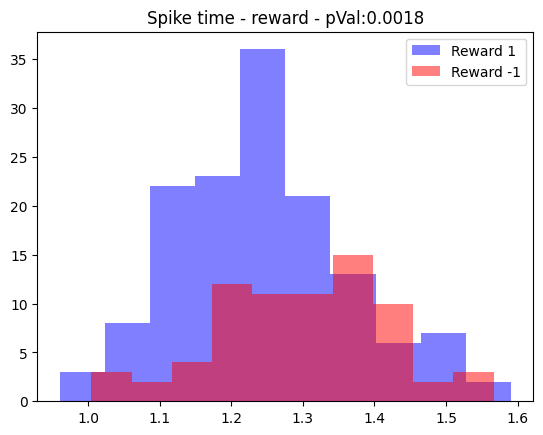

In [21]:
# Plot histograms
plt.hist(f1,  alpha=0.5, color='blue', label='Reward 1')
plt.hist(f2,  alpha=0.5, color='red', label='Reward -1')

# Add legend and title
plt.legend(loc='upper right')
plt.title('Spike time - reward - pVal:' + str(round(p_val,4)))
# Display the plot
plt.show()

preprocessing

In [22]:
import pandas as pd

# Extract 'brain_area' data and identify 'SUB' cells
brain_areas = dataset['brain_area'].to_dataframe()
sub_cell_indices = brain_areas[brain_areas['brain_area'] == 'SUB'].index

# Process 'spike_rate' data for 'SUB' cells
spike_rate_data = dataset['spike_rate'].to_dataframe().reset_index()
sub_spike_rate = spike_rate_data[spike_rate_data['cell'].isin(sub_cell_indices)]
avg_spike_rate_per_trial = sub_spike_rate.groupby(['trial', 'cell']).mean()['spike_rate']
avg_spike_rate = avg_spike_rate_per_trial.groupby('trial').mean()

# Process 'spike_time' data for 'SUB' cells
spike_time_data = dataset[['spike_time', 'spike_cell', 'spike_trial']].to_dataframe()
sub_spike_time = spike_time_data[spike_time_data['spike_cell'].isin(sub_cell_indices)]
avg_spike_time_per_trial = sub_spike_time.groupby(['spike_trial', 'spike_cell']).mean()['spike_time']
avg_spike_time = avg_spike_time_per_trial.groupby('spike_trial').mean()

# Extract 'reaction_time' data
reaction_times = dataset['reaction_time'].to_dataframe().values.flatten()

# Construct the final dataframe
df = pd.DataFrame({
    'reaction_time': reaction_times,
    'spike_time': avg_spike_time,
    'spike_rate': avg_spike_rate
})


In [24]:
df = df.reset_index()
df

,index,reaction_time,spike_time,spike_rate
0,1,170.0,1.134605,0.079307
1,2,230.0,1.268446,0.067573
2,3,200.0,1.088225,0.055947
3,4,860.0,1.205556,0.056853
4,5,140.0,1.177878,0.063520
...,...,...,...,...
359,360,NaN,1.251748,0.090987
360,361,NaN,1.258168,0.073333
361,362,NaN,1.285870,0.083840
362,363,NaN,1.120888,0.090827


In [25]:
# Extract feedback types and identify positive and negative indices
feedback_types = dataset['feedback_type'].to_dataframe()
positive_indices = feedback_types[feedback_types['feedback_type'] == 1].index.to_list()
negative_indices = feedback_types[feedback_types['feedback_type'] == -1].index.to_list()

# Filter the main dataframe based on feedback type indices
f1 = df.iloc[positive_indices, :]
f2 = df.iloc[negative_indices, :]


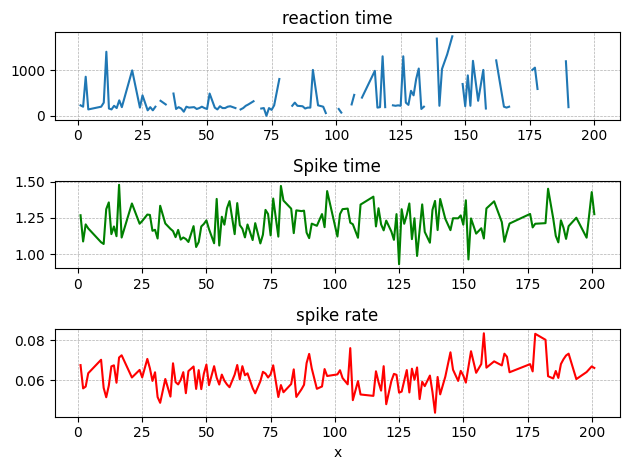

In [31]:

plt.subplot(3, 1, 1)  # (nrows, ncols, index)
plt.plot(f1.index, f1.reaction_time)
plt.title('reaction time')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Second subplot
plt.subplot(3, 1, 2)
plt.plot(f1.index, f1.spike_time, color='green')
plt.title('Spike time')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Third subplot
plt.subplot(3, 1, 3)
plt.plot(f1.index, f1.spike_rate, color='red')
plt.title('spike rate')
plt.xlabel('x')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the subplots
plt.show()

In [110]:
df = dataset['lfp'].to_dataframe().reset_index()
df

,brain_area_lfp,trial,time,lfp
0,ACA,1,0.01,-2.850794
1,ACA,1,0.02,-4.039683
2,ACA,1,0.03,-4.195238
3,ACA,1,0.04,-3.228571
4,ACA,1,0.05,0.460317
...,...,...,...,...
636995,VISp,364,2.46,6.761410
636996,VISp,364,2.47,11.952319
636997,VISp,364,2.48,15.552319
636998,VISp,364,2.49,16.043228


In [116]:
import numpy as np

In [250]:
import itertools

s = sorted(list(set(df.brain_area_lfp)))
pairs = list(itertools.combinations(s, 2))
pairs

[('ACA', 'CA3'),
 ('ACA', 'DG'),
 ('ACA', 'LS'),
 ('ACA', 'MOs'),
 ('ACA', 'SUB'),
 ('ACA', 'VISp'),
 ('CA3', 'DG'),
 ('CA3', 'LS'),
 ('CA3', 'MOs'),
 ('CA3', 'SUB'),
 ('CA3', 'VISp'),
 ('DG', 'LS'),
 ('DG', 'MOs'),
 ('DG', 'SUB'),
 ('DG', 'VISp'),
 ('LS', 'MOs'),
 ('LS', 'SUB'),
 ('LS', 'VISp'),
 ('MOs', 'SUB'),
 ('MOs', 'VISp'),
 ('SUB', 'VISp')]

In [258]:
conn_mat = np.array([1,2,3,4,5,6,7,8,9,10,11])
name_list = ['SUB-ACA',	'SUB-CA3',	'SUB-DG',	'SUB-LS',	'SUB-Mos',	'SUB-VISp',	'VISp-ACA',	'VISp-CA3',	'VISp-DG',	'VISp-LS',	'VISp-Mos',]

In [328]:
conn_mat_trial = np.zeros((7,7,1))


In [329]:
for i in set(df.trial):
    i_trial = df[df.trial==i]
    tmp_time_trial = i_trial[['lfp']].values.reshape((7,-1))
    correlation_matrix = np.corrcoef(tmp_time_trial)
    sub_mat = correlation_matrix[np.r_[0:5, 6],5]
    v_mat = correlation_matrix[:-2,6]
    merge_mat = np.hstack([sub_mat, v_mat])
    conn_mat = np.vstack([conn_mat,merge_mat])
    conn_mat_trial = np.concatenate((conn_mat_trial, correlation_matrix.reshape((7,7,1))), axis=2)

# Compute the correlation matrix


['SUB', 'CA3', 'LS', 'ACA', 'VISp', 'DG', 'MOs']

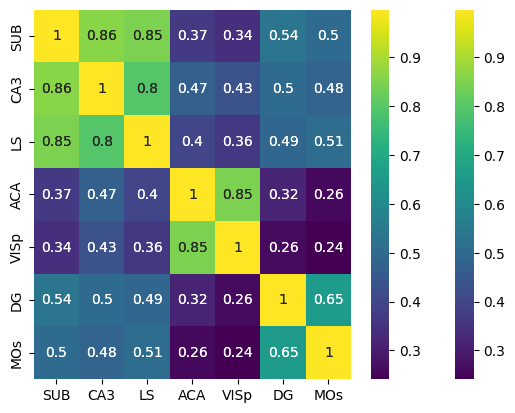

In [334]:
import seaborn as sns
sns.heatmap(conn_mat_trial.mean(axis=2), annot=True, cmap='viridis')
# Sample labels
labels_list = list(set(df.brain_area_lfp))

# Create a heatmap with labels
sns.heatmap(conn_mat_trial.mean(axis=2), annot=True, cmap='viridis',
            xticklabels=labels_list, yticklabels=labels_list)

# Display the plot
plt.show()

In [275]:
data = conn_mat[1:,:]
feedback_df = dataset['feedback_type'].to_dataframe()
non_nan_indices = feedback_df.notna()
data = data[non_nan_indices.feedback_type.values,:]
label = feedback_df.dropna().values

In [289]:
from sklearn import datasets
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# clf = SVC(kernel='rbf',probability=True)
# clf.fit(X_train_scaled, y_train)

# y_pred = clf.predict(X_test_scaled)
# accuracy = accuracy_score(y_test.ravel(), y_pred)
# accuracy

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.6511627906976745

In [ ]:
# Hyperparameter tuning with GridSearchCV
parameters = {
    'C': np.linspace(0.1,100,1000),
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']
}

svc = SVC(probability=True)
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X_train_scaled, y_train)

# Train the SVM with best parameters
best_svc = clf.best_estimator_

# Predict on the test set
y_pred = best_svc.predict(X_test_scaled)
accuracy = accuracy_score(y_test.reshape((-1,)), y_pred)

In [306]:
accuracy

0.6744186046511628

In [223]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.4 MB/s eta 0:00:00


In [307]:
import shap


  0%|          | 0/43 [00:00<?, ?it/s]

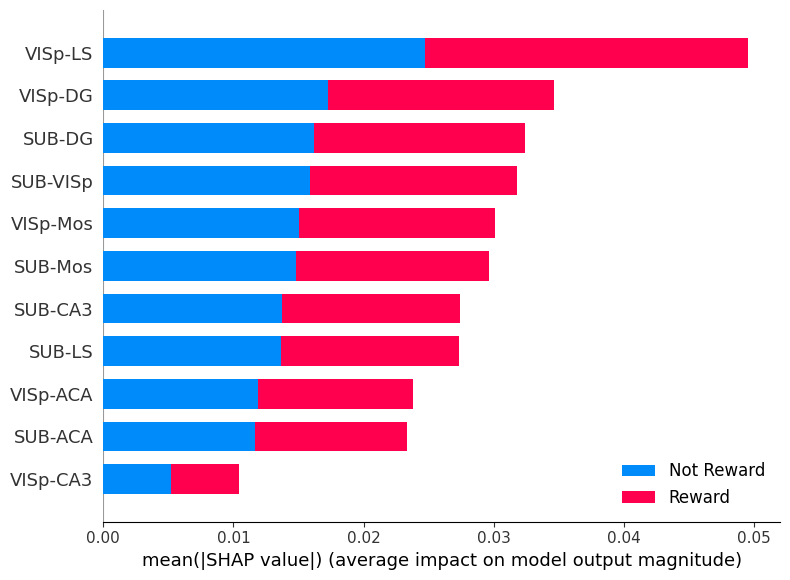

In [310]:
# Use SHAP's KernelExplainer for non-tree models
explainer = shap.KernelExplainer(best_svc.predict_proba, X_train_scaled, link="logit")
shap_values = explainer.shap_values(X_test_scaled)

# Plot the SHAP values
shap.summary_plot(shap_values, X_test_scaled, feature_names=name_list, class_names=['Reward','Not Reward'])